In [2]:
!pip install transformers
!pip install plotly
!pip install cufflinks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00


In [3]:
import gym
import numpy as np
from gym import spaces
from transformers import BertTokenizerFast
import pandas as pd
import torch
from transformers import BertTokenizerFast, DistilBertForSequenceClassification
from torch.distributions import Categorical
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/jaxlib/xla_client.py:225: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  float8_e4m3b11fnuz = ml_dtypes.float8_e4m3b11


In [4]:
class LabelingEnv(gym.Env):
  def __init__(self, instances, labels):
    super(LabelingEnv, self).__init__()
    self.instances = instances
    self.labels = labels
    self.current_instance = 0
    self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    encoded = self.tokenizer([self.instances[self.current_instance]], return_tensors='pt', padding='max_length', truncation=True, max_length=64, return_token_type_ids=False)

    #define the output of the model
    self.action_space = spaces.Discrete(2)
    self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1, 64))

  def step(self, action):
    reward = 1 if action == self.labels[self.current_instance] else -1
    self.current_instance += 1
    done = self.current_instance == len(self.instances)
    if done:
      next_state = None
    else:
        encoded = self.tokenizer([self.instances[self.current_instance]], return_tensors='pt', padding='max_length', truncation=True, max_length=64, return_token_type_ids=False)
        next_state = { 'input_ids': encoded['input_ids'], 'attention_mask': encoded['attention_mask'] }
    return next_state, reward, done


  def reset(self):
    self.current_instance = 0
    encoded = self.tokenizer([self.instances[self.current_instance]], return_tensors='pt', padding='max_length', truncation=True, max_length=64, return_token_type_ids=False)
    return { 'input_ids': encoded['input_ids'], 'attention_mask': encoded['attention_mask'] }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


In [6]:
#loading model from BERT
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') # 2 labels: Slang, No Slang
for param in model.base_model.parameters():
    param.requires_grad = False
tokenizer = BertTokenizerFast.from_pretrained('distilbert-base-uncased')

optimizer = Adam(model.parameters(), lr=1e-5)

df = pd.read_csv('/content/drive/MyDrive/BERT Models/Dataset/mergedData.csv') #the file directory
df.drop_duplicates(subset = ['sentence'], inplace = True)

instances = df['sentence'].tolist()
labels = df['label'].tolist()

#custom envinronment
env = LabelingEnv(instances, labels)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.we

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from IPython.display import clear_output

kf = KFold(n_splits=5, shuffle=True, random_state=42)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

all_rewards = []

for fold, (train_index, test_index) in enumerate(kf.split(instances)):
    print(f'Starting Fold {fold+1}...')
    train_instances = [instances[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    test_instances = [instances[i] for i in test_index]
    test_labels = [labels[i] for i in test_index]

    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased') # 2 labels: Slang, No Slang
    for param in model.base_model.parameters():
        param.requires_grad = False
    model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-5)

    env = LabelingEnv(train_instances, train_labels)

    n = 50
    model.train()
    fold_rewards = []
    for epoch in tqdm(range(n), desc = 'Epochs'):
        state = env.reset()
        done = False
        epoch_rewards = []
        pbar = tqdm(total=len(env.instances), desc=f'Epoch {epoch + 1}', leave=False)
        while not done:
            if state is not None:
                state = {k: v.to(device) for k, v in state.items()}
                outputs = model(**state)

                probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

                dist = Categorical(probs[0])
                action = dist.sample()

                new_state, reward, done = env.step(action.item())
                epoch_rewards.append(reward)

                loss = -dist.log_prob(action) * reward

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                state = new_state if new_state is not None else None

                # pbar.update(1)
            else:
                break
        pbar.close()
        fold_rewards.append(np.sum(epoch_rewards))
        print(f'\nEpoch {epoch + 1}: Total rewards {np.sum(epoch_rewards)}')

    print(f'Validating on Fold {fold+1}...')
    env = LabelingEnv(test_instances, test_labels)
    model.eval()
    preds = []
    with torch.no_grad():
        for instance in test_instances:
            encoded = tokenizer([instance], return_tensors='pt', padding='max_length', truncation=True, max_length=64, return_token_type_ids=False)
            encoded = {k: v.to(device) for k, v in encoded.items()}
            outputs = model(**encoded)
            _, predicted = torch.max(outputs.logits, dim=1)
            preds.append(predicted.item())
    all_rewards.append(fold_rewards)
    accuracy = accuracy_score(test_labels, preds)
    precision = precision_score(test_labels, preds)
    recall = recall_score(test_labels, preds)
    f1 = f1_score(test_labels, preds)

    print(f'Validation results for Fold {fold+1}: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}\n')
    time.sleep(0.1)
    clear_output(wait=True)

Starting Fold 5...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.we


Epoch 1: Total rewards 1803



Epochs:   4%|▍         | 2/50 [00:43<17:30, 21.88s/it]


Epoch 2: Total rewards 1973



Epochs:   6%|▌         | 3/50 [01:10<18:44, 23.93s/it]


Epoch 3: Total rewards 1977



Epochs:   8%|▊         | 4/50 [01:31<17:34, 22.92s/it]


Epoch 4: Total rewards 1975



Epochs:  10%|█         | 5/50 [01:54<17:08, 22.86s/it]


Epoch 5: Total rewards 1973



Epochs:  12%|█▏        | 6/50 [02:15<16:25, 22.40s/it]


Epoch 6: Total rewards 1977



Epochs:  14%|█▍        | 7/50 [02:38<16:07, 22.51s/it]


Epoch 7: Total rewards 1977



Epochs:  16%|█▌        | 8/50 [02:59<15:28, 22.11s/it]


Epoch 8: Total rewards 1977



Epochs:  18%|█▊        | 9/50 [03:22<15:13, 22.29s/it]


Epoch 9: Total rewards 1977



Epochs:  20%|██        | 10/50 [03:43<14:39, 22.00s/it]


Epoch 10: Total rewards 1977



Epochs:  22%|██▏       | 11/50 [04:06<14:26, 22.22s/it]


Epoch 11: Total rewards 1977



Epochs:  24%|██▍       | 12/50 [04:28<13:55, 21.98s/it]


Epoch 12: Total rewards 1977



Epochs:  26%|██▌       | 13/50 [04:50<13:40, 22.17s/it]


Epoch 13: Total rewards 1977



Epochs:  28%|██▊       | 14/50 [05:12<13:09, 21.92s/it]


Epoch 14: Total rewards 1977



Epochs:  30%|███       | 15/50 [05:34<12:56, 22.19s/it]


Epoch 15: Total rewards 1977



Epochs:  32%|███▏      | 16/50 [05:56<12:24, 21.90s/it]


Epoch 16: Total rewards 1977



Epochs:  34%|███▍      | 17/50 [06:18<12:06, 22.02s/it]


Epoch 17: Total rewards 1977



Epochs:  36%|███▌      | 18/50 [06:39<11:37, 21.80s/it]


Epoch 18: Total rewards 1977



Epochs:  38%|███▊      | 19/50 [07:02<11:23, 22.04s/it]


Epoch 19: Total rewards 1977



Epochs:  40%|████      | 20/50 [07:23<10:57, 21.91s/it]


Epoch 20: Total rewards 1977



Epochs:  42%|████▏     | 21/50 [07:46<10:41, 22.11s/it]


Epoch 21: Total rewards 1977



Epochs:  44%|████▍     | 22/50 [08:08<10:15, 21.98s/it]


Epoch 22: Total rewards 1977



Epochs:  46%|████▌     | 23/50 [08:30<09:54, 22.00s/it]


Epoch 23: Total rewards 1977



Epochs:  48%|████▊     | 24/50 [08:52<09:34, 22.08s/it]


Epoch 24: Total rewards 1977



Epochs:  50%|█████     | 25/50 [09:18<09:38, 23.15s/it]


Epoch 25: Total rewards 1977



Epochs:  52%|█████▏    | 26/50 [09:39<09:03, 22.66s/it]


Epoch 26: Total rewards 1977



Epochs:  54%|█████▍    | 27/50 [10:02<08:42, 22.72s/it]


Epoch 27: Total rewards 1977



Epochs:  56%|█████▌    | 28/50 [10:23<08:10, 22.29s/it]


Epoch 28: Total rewards 1977



Epochs:  58%|█████▊    | 29/50 [10:46<07:52, 22.49s/it]


Epoch 29: Total rewards 1977



Epochs:  60%|██████    | 30/50 [11:08<07:24, 22.20s/it]


Epoch 30: Total rewards 1977



Epochs:  62%|██████▏   | 31/50 [11:31<07:06, 22.43s/it]


Epoch 31: Total rewards 1977



Epochs:  64%|██████▍   | 32/50 [11:56<06:57, 23.20s/it]


Epoch 32: Total rewards 1977



Epochs:  66%|██████▌   | 33/50 [12:18<06:31, 23.02s/it]


Epoch 33: Total rewards 1977



Epochs:  68%|██████▊   | 34/50 [12:40<06:03, 22.73s/it]


Epoch 34: Total rewards 1977



Epochs:  70%|███████   | 35/50 [13:03<05:41, 22.75s/it]


Epoch 35: Total rewards 1977



Epochs:  72%|███████▏  | 36/50 [13:32<05:43, 24.54s/it]


Epoch 36: Total rewards 1977



Epochs:  74%|███████▍  | 37/50 [13:54<05:08, 23.73s/it]


Epoch 37: Total rewards 1977



Epochs:  76%|███████▌  | 38/50 [14:17<04:41, 23.48s/it]


Epoch 38: Total rewards 1977



Epochs:  78%|███████▊  | 39/50 [14:38<04:12, 22.92s/it]


Epoch 39: Total rewards 1977



Epochs:  80%|████████  | 40/50 [15:02<03:53, 23.30s/it]


Epoch 40: Total rewards 1977



Epochs:  82%|████████▏ | 41/50 [15:24<03:24, 22.76s/it]


Epoch 41: Total rewards 1977



Epochs:  84%|████████▍ | 42/50 [15:47<03:02, 22.83s/it]


Epoch 42: Total rewards 1977



Epochs:  86%|████████▌ | 43/50 [16:14<02:48, 24.00s/it]


Epoch 43: Total rewards 1977



Epochs:  88%|████████▊ | 44/50 [16:39<02:26, 24.47s/it]


Epoch 44: Total rewards 1977



Epochs:  90%|█████████ | 45/50 [17:02<02:00, 24.01s/it]


Epoch 45: Total rewards 1977



Epochs:  92%|█████████▏| 46/50 [17:24<01:33, 23.31s/it]


Epoch 46: Total rewards 1977



Epochs:  94%|█████████▍| 47/50 [17:47<01:09, 23.25s/it]


Epoch 47: Total rewards 1977



Epochs:  96%|█████████▌| 48/50 [18:08<00:45, 22.67s/it]


Epoch 48: Total rewards 1977



Epochs:  98%|█████████▊| 49/50 [18:31<00:22, 22.64s/it]


Epoch 49: Total rewards 1977



Epochs: 100%|██████████| 50/50 [18:52<00:00, 22.65s/it]



Epoch 50: Total rewards 1977
Validating on Fold 5...
Validation results for Fold 5: Accuracy: 0.8646496815286624, Precision: 0.0, Recall: 0.0, F1-score: 0.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import plotly.graph_objects as go
import cufflinks as cf
import pandas as pd

all_rewards_df = pd.DataFrame(all_rewards).T

moving_avg_rewards = all_rewards_df.rolling(window=5).mean()

fig = go.Figure()
for fold in range(5):
    fig.add_trace(go.Scatter(x=list(range(len(moving_avg_rewards))),
                             y=moving_avg_rewards[fold],
                             mode='lines',
                             name=f'Fold {fold+1}'))

fig.update_layout(title='Moving Average Rewards per Epoch for each fold',
                   xaxis_title='Epoch',
                   yaxis_title='Moving Average Rewards')

fig.show()

In [9]:
model.save_pretrained('/content/drive/MyDrive/Content/BERT RL biased/model')
tokenizer.save_pretrained('/content/drive/MyDrive/Content/BERT RL biased/tokenizer')
import pickle

with open("/content/drive/MyDrive/Content/BERT RL biased/instances", "wb") as f:
    pickle.dump(instances, f)

with open("/content/drive/MyDrive/Content/BERT RL biased/labels", "wb") as f:
    pickle.dump(labels, f)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Test results: Accuracy: 0.96, Precision: 0.0, Recall: 0.0, F1-score: 0.0


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        96
           1       0.00      0.00      0.00         4

    accuracy                           0.96       100
   macro avg       0.48      0.50      0.49       100
weighted avg       0.92      0.96      0.94       100


Confusion Matrix:


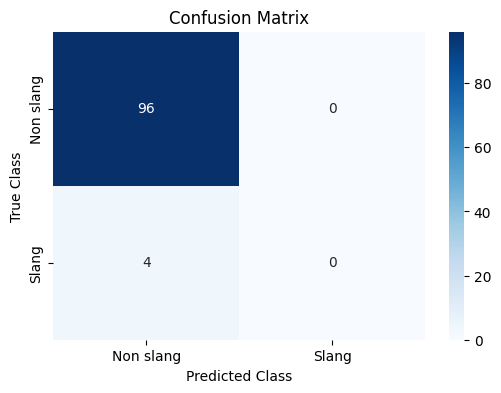

In [19]:
from transformers import BertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import seaborn as sb
import pandas as pd
import torch

model_dir = '/content/drive/MyDrive/Content/BERT RL biased/model'
tokenizer_dir = '/content/drive/MyDrive/Content/BERT RL biased/tokenizer'

model = DistilBertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_dir)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

test_df = pd.read_csv('/content/drive/MyDrive/BERT Models/Dataset/mergedDataTest.csv', delimiter = ';')
test_instances = test_df['sentence'].tolist()
test_labels = test_df['label'].tolist()

env = LabelingEnv(test_instances, test_labels)
model.eval()
preds = []
with torch.no_grad():
    for instance in test_instances:
        encoded = tokenizer([instance], return_tensors='pt', padding='max_length', truncation=True, max_length=64, return_token_type_ids=False)
        encoded = {k: v.to(device) for k, v in encoded.items()}
        outputs = model(**encoded)
        _, predicted = torch.max(outputs.logits, dim=1)
        preds.append(predicted.item())

accuracy = accuracy_score(test_labels, preds)
precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)
f1 = f1_score(test_labels, preds)
conf_matrix = confusion_matrix(test_labels, preds)
class_report = classification_report(test_labels, preds)

print(f'Test results: Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}\n')
print('\nClassification Report:')
print(class_report)
print('\nConfusion Matrix:')
labels = ['Non slang', 'Slang']
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
plt.figure(figsize=(6, 4))
sb.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()